<a href="https://colab.research.google.com/github/Sky-rain8848/Hands-On-ML-with-SKT/blob/master/Resnet_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Implementing a ResNet-34 CNN Using Keras**

ResNet-34 is the ResNet with 34 layers (only counting the convolutional layers and the fully connected layer) containing 3 residual units that output 64 feature maps, 4 RUs with 128 maps, 6 RUs with 256 maps, and 3 RUs with 512 maps.

# Create a ResidualUnit layer

Each residual unit is composed of two convolutional layers (and no pooling layer!), with Batch Normalization(BN) and ReLU activation, using 3 × 3 kernels and preserving spatial dimensions (stride 1, "same" padding).

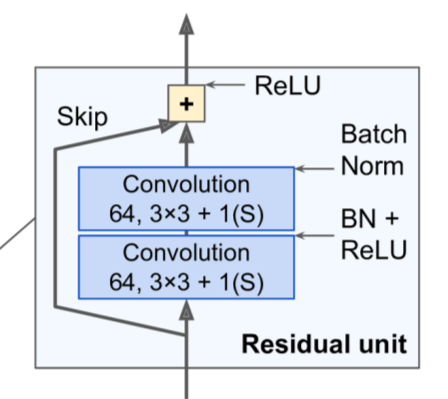



In [39]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,                 # fix parameters
                        padding="SAME", use_bias=False)

In [41]:
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)                    # Inherit the parameters used in the Model method      
        self.activation = keras.activations.get(activation)      # get activation function
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)
        

In [42]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 56, 56, 64)        7

# **Using Pretrained Models from Keras**

In general, you won’t have to implement standard models manually, since pretrained networks are readily available with a single line of code in
the <font color="#006666">keras.applications</font> package. 


In [34]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import load_sample_image

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])                  
batch_size, height, width, channels = images.shape         # 4D tensor of shape [minibatch size, height, width, channels]

In [ ]:
def plot_color_image(image):
    plt.imshow(image)   
    plt.axis("off")

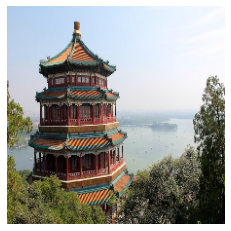

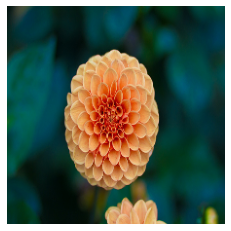

In [ ]:
images_resized = tf.image.resize(images, [224, 224])   # A ResNet-50 model expects 224 × 224-pixel images
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

# Using <font color="#006666">tf.image.crop_and_resize</font> to crop the images
<font color="#006666">tf.image.crop_and_resize(image, boxes, box_indices, crop_size)</font><br>

<font color="#006666">boxes: </font> Range to be cropped, and is specified in normalized coordinates[ymin，xmin，ymax，xmax]\
<font color="#006666">box_indices:</font> The value of box_ind[i] specifies the image that the i-th box refers to.\
<font color="#006666">crop_size: </font>All cropped image patches are resized to this size. 



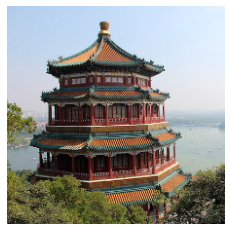

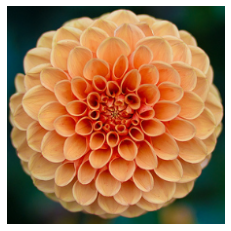

In [ ]:
china_box = [0, 0.03, 1, 0.68]                 
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

# Using the ResNet-50 model pretrained on ImageNet

In [ ]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")   

<font color="#006666">tf.keras.applications.resnet.preprocess_input</font> is commonly used to preprossing the data, including normalization and whitening.\
The output <font color="#006666">Y_proba</font> is a matrix with one row per image and one column per
class (in this case, there are 1,000 classes). 

In [ ]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_proba = model.predict(inputs)

Use <font color="#006666">tf.keras.applications.resnet.decode_predictions</font> to display the top K predictions, including the class name and the estimated probability of each predicted class

In [ ]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3) 
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

40960/35363 [==================================] - 0s 0us/step
Image #0
  n03877845 - palace       43.39%
  n02825657 - bell_cote    43.07%
  n03781244 - monastery    11.70%

Image #1
  n04522168 - vase         53.96%
  n07930864 - cup          9.52%
  n11939491 - daisy        4.97%

